In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/PCRD_model

Mounted at /content/drive
/content/drive/MyDrive/PCRD_model


# Photo Preprocessing

In [13]:
# import
import os
import numpy as np
import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras import models

from cv2 import imread, IMREAD_GRAYSCALE
from pandas import read_csv
# import matplotlib.pyplot as plt

In [14]:
# Seed
SEED = 1234
tf.random.set_seed(SEED)

# Image Size
IMG_SIZE = (200, 504, 1)

In [16]:
PATH = "training_data"
file_dir = os.listdir(PATH)
file_dir.sort()
X_train = np.array([])

tmp = []

prep = read_csv("auto_label.csv")
N = 0

for i in range(len(file_dir)):
    if prep['label'][i]:
        img = imread(PATH + "/" + file_dir[i], IMREAD_GRAYSCALE)
        img = np.expand_dims(img[:], axis = 2)
        tmp.append(img)
        N += 1

X_train = np.array(tmp) / 255

# Prepare y_train
data = read_csv("color_label.csv")
y_train = data["label"]
y_train = np.expand_dims(y_train[:N], axis = 1)

## Data Split

In [17]:
# Shuffle
from sklearn.model_selection import train_test_split

val_split = 0.1
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=val_split, stratify=y_train)

# X_train = np.concatenate((X_t, X_v))
# y_train = np.concatenate((y_t, y_v))

In [18]:
!pip install keras_preprocessing

In [19]:
# Data augmentation and splitting data
from keras_preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.3, validation_split=0.1)
training = train_datagen.flow(X_train, y_train, batch_size=32, subset='training')
validation = train_datagen.flow(X_train, y_train, batch_size=16, subset='validation')

# Linear Model

In [20]:
# Linear model
training_linearX = np.reshape(training.x, (training.x.shape[0], -1))
validation_linearX = np.reshape(validation.x, (validation.x.shape[0], -1))

model_linear = tf.keras.models.Sequential()
model_linear.add(tf.keras.layers.Dense(1))

model_linear.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),])

history_linear = model_linear.fit(training_linearX, training.y, batch_size=16, epochs=1, validation_data=(validation_linearX, validation.y))

4/4 [==============================] - 1s 110ms/step - loss: 10.0676 - binary_accuracy: 0.3333 - val_loss: 7.6246 - val_binary_accuracy: 0.5000


In [21]:
X_test_linear = np.reshape(X_test, (X_test.shape[0], -1))

predict_linear = model_linear.predict(X_test_linear) #; print(predict_linear)

predict_linear = (predict_linear > 0.5).astype('int32').flatten()

from sklearn.metrics import f1_score
score_linear = f1_score(y_test, predict_linear); print(score_linear)

# mse_linear = tf.keras.losses.mean_squared_error(y_test, predict_linear).numpy(); print(mse_linear)
# mae_linear = tf.keras.losses.mean_absolute_error(y_test, predict_linear).numpy(); print(mae_linear)

1/1 [==============================] - 0s 69ms/step
0.7692307692307693


In [22]:
y_train

array([[1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1]])

# CNN Model

In [33]:
# build model
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=IMG_SIZE))
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(64, 2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, strides=2))
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, padding='same'))
# model.add(Activation('relu'))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(), ])

model.summary()

history = model.fit(training, batch_size=8, epochs=20, validation_data=validation)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 200, 504, 64)      640       
                                                                 
 conv2d_7 (Conv2D)           (None, 200, 504, 64)      16448     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 100, 252, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 100, 252, 64)      36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 50, 126, 64)       0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 403200)           

1/1 [==============================] - 1s 889ms/step - loss: 0.7275 - binary_accuracy: 0.3333


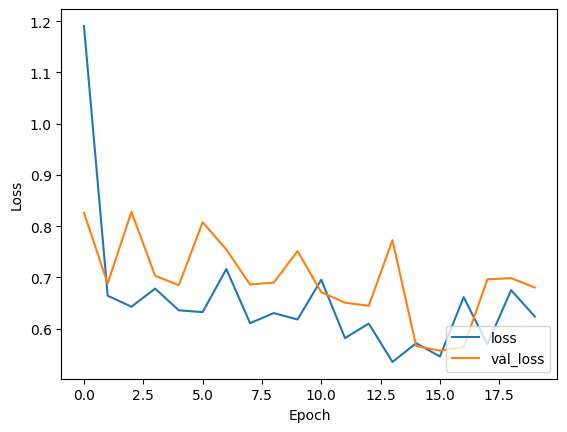

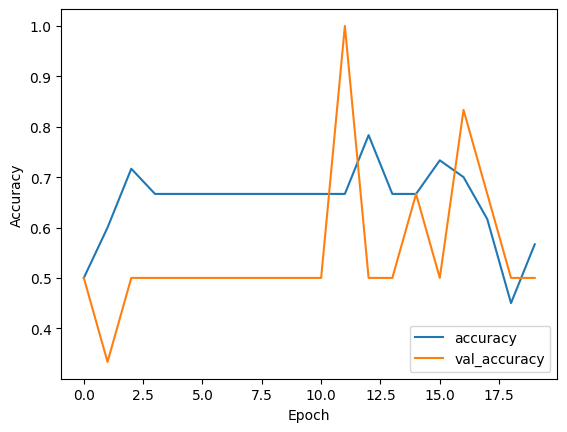

In [34]:
import matplotlib.pyplot as plt
# plot loss curve
plt.figure(1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

# plot accuracy curve
plt.figure(2)
plt.plot(history.history['binary_accuracy'], label='accuracy')
plt.plot(history.history['val_binary_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

train_acc = model.evaluate(training)
val_acc = model.evaluate(validation)

In [35]:
predict = model.predict(X_test)

predict = (predict > 0.5).astype('int32').flatten()

from sklearn.metrics import f1_score
score = f1_score(y_test, predict); print(score)
# mse = tf.keras.losses.mean_squared_error(y_test, predict).numpy(); print(mse)
# mae = tf.keras.losses.mean_absolute_error(y_test, predict).numpy(); print(mae)

1/1 [==============================] - 2s 2s/step
0.7692307692307693


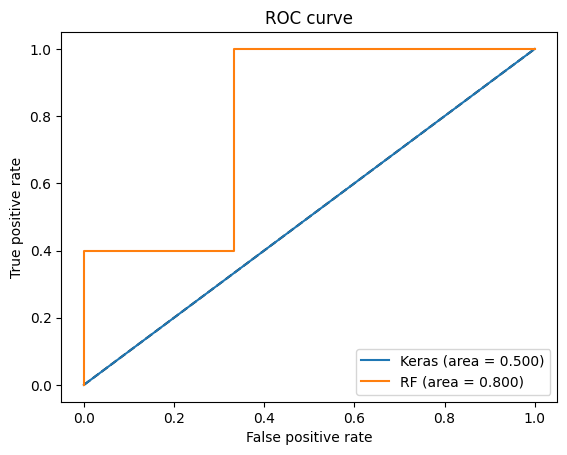

In [39]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, predict.ravel())

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(training_linearX, training.y.ravel())

y_pred_rf = rf.predict_proba(X_test_linear)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(3)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# # Zoom in view of the upper left corner.
# plt.figure(4)
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()

# Save Model

In [42]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('result_model.tflite', 'wb') as f:
  f.write(tflite_model)